In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Generator:

The encoder-decoder architecture consists of:

ancoder :

C64-C128-C256-C512-C512-C512-C512-C512

decoder :

CD512-CD512-CD512-CD512-C256-C128-C64

C=concolution  
CD = convolution and droupout

Discriminator

C64-C128-C256-C512

After the last layer, a convolution is applied to map

to a 1-dimensionaloutput, followed by a sigmoid function.


In [ ]:
!pip install keras

In [16]:
import tensorflow

In [17]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [18]:
def define_discriminator(image_shape):

    # weight initialization
    init = RandomNormal(stddev=0.02) #As described in the original paper

    # source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [19]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [20]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [21]:
def define_generator(image_shape=(256,256,3)):
    # weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

In [22]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [23]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y


In [24]:


def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [25]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [26]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, dataset)
            d_model.save(f"model_d_{i}.h5")
            gan_model.save(f"model_gan_{i}.h5")
    # 		if (i+1) % (bat_per_epo * 10) == 0:
    # 			summarize_performance(i, g_model, dataset)

Now dealing with data


In [27]:
"""
Satellite image to maps image translation ​using Pix2Pix GAN

Data from: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Also find other datasets here: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/
"""

from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [50]:
# from os import listdir
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from numpy import asarray

def load_images(path):
    src_list = list()

    # Access satellite images
    satellite_path = path + 'x/'
    for x_folder in listdir(satellite_path):
        x_folder_path = satellite_path + x_folder + '/'
        for filename in listdir(x_folder_path):
            # Load and resize the satellite image
            pixels = load_img(x_folder_path + filename, target_size=(256, 256))
            # Convert to numpy array
            pixels = img_to_array(pixels)
            src_list.append(pixels)
    
    
    return [asarray(src_list)]


In [51]:
path="./image_broken/"

In [52]:
# load dataset
[src_images] = load_images(path)
print('Loaded: ', src_images.shape)

Loaded:  (216, 256, 256, 3)


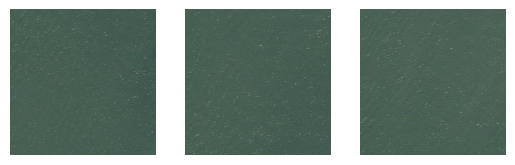

In [53]:

n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
pyplot.show()

#######################################

In [54]:
# from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images]

In [55]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1 = data[0]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	return [X1]


In [56]:
dataset = preprocess_data(data)

In [35]:
from keras.models import load_model
from numpy.random import randint

In [36]:
from keras.models import load_model
from numpy.random import randint
model = load_model('./model_save_perepoch/fifth_2_epoch/model_002592.h5')

In [57]:
def plot_images(src_img, gen_img):
	images = vstack((src_img, gen_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 0s 377ms/step


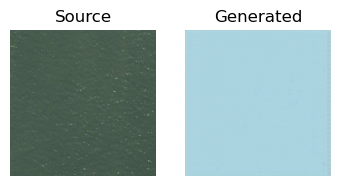

In [58]:
[X1] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image = X1[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image)

In [59]:
import os
import numpy as np
from PIL import Image
from keras.models import load_model


# List of OSM images (replace with your list of images)
[osm_images]  = dataset  # List of image data

# Create the main output folder
output_folder = 'predicted_broken_images_left'
os.makedirs(output_folder, exist_ok=True)

# Define the range of subfolders and images
start_subfolder = 77149
end_subfolder = 77272
start_image = 98530
end_image = 98637



# Number of images per subfolder
y_images_per_folder = end_image - start_image + 1  # Number of images per subfolder

# Number of images per output subfolder (adjust as needed)
images_per_output_subfolder = 108

# Initialize variables to keep track of the current output subfolder and image count
current_output_subfolder = None
current_image_count = 0
i = 0
# Iterate through the list of OSM images and make predictions
for subfolder_index in range(start_subfolder, end_subfolder + 1):
    # Create a subfolder named after the image index
    subfolder_name = str(subfolder_index)
    subfolder_path = os.path.join(output_folder, subfolder_name)
    os.makedirs(subfolder_path, exist_ok=True)
    
    
    # Iterate through the range of images for this subfolder
    for image_index in range(start_image, end_image + 1):
        # Make a prediction
          # Index within the range
        osm_image = osm_images[i]  # Use the corresponding input image
        prediction = model.predict(np.expand_dims(osm_image, axis=0))[0]
#         prediction = model.predict(osm_image)


        # Save the predicted image in the current subfolder
        predicted_image = Image.fromarray((prediction * 255).astype(np.uint8))
        image_filename = str(image_index) + '.png'
        image_path = os.path.join(subfolder_path, image_filename)
        predicted_image.save(image_path)

        # Increment the current image count
        current_image_count += 1
        i+=1

        # Check if we need to create a new output subfolder
        if current_image_count % images_per_output_subfolder == 0:
            current_output_subfolder = None

        print(f'Saved prediction for image {image_index} in folder {subfolder_name}')

    # Reset the current image count for the next subfolder
    current_image_count = 0


1/1 [==============================] - 0s 376ms/step
Saved prediction for image 98530 in folder 77149
1/1 [==============================] - 0s 371ms/step
Saved prediction for image 98531 in folder 77149
1/1 [==============================] - 0s 358ms/step
Saved prediction for image 98532 in folder 77149
1/1 [==============================] - 0s 248ms/step
Saved prediction for image 98533 in folder 77149
1/1 [==============================] - 0s 342ms/step
Saved prediction for image 98534 in folder 77149
1/1 [==============================] - 0s 365ms/step
Saved prediction for image 98535 in folder 77149
1/1 [==============================] - 0s 267ms/step
Saved prediction for image 98536 in folder 77149
1/1 [==============================] - 0s 351ms/step
Saved prediction for image 98537 in folder 77149
1/1 [==============================] - 0s 266ms/step
Saved prediction for image 98538 in folder 77149
1/1 [==============================] - 0s 317ms/step
Saved prediction for image 98

1/1 [==============================] - 0s 397ms/step
Saved prediction for image 98610 in folder 77149
1/1 [==============================] - 0s 444ms/step
Saved prediction for image 98611 in folder 77149
1/1 [==============================] - 0s 411ms/step
Saved prediction for image 98612 in folder 77149
1/1 [==============================] - 0s 426ms/step
Saved prediction for image 98613 in folder 77149
1/1 [==============================] - 0s 399ms/step
Saved prediction for image 98614 in folder 77149
1/1 [==============================] - 0s 381ms/step
Saved prediction for image 98615 in folder 77149
1/1 [==============================] - 0s 390ms/step
Saved prediction for image 98616 in folder 77149
1/1 [==============================] - 0s 379ms/step
Saved prediction for image 98617 in folder 77149
1/1 [==============================] - 0s 472ms/step
Saved prediction for image 98618 in folder 77149
1/1 [==============================] - 0s 428ms/step
Saved prediction for image 98

1/1 [==============================] - 0s 383ms/step
Saved prediction for image 98582 in folder 77150
1/1 [==============================] - 0s 420ms/step
Saved prediction for image 98583 in folder 77150
1/1 [==============================] - 0s 404ms/step
Saved prediction for image 98584 in folder 77150
1/1 [==============================] - 0s 412ms/step
Saved prediction for image 98585 in folder 77150
1/1 [==============================] - 0s 461ms/step
Saved prediction for image 98586 in folder 77150
1/1 [==============================] - 0s 480ms/step
Saved prediction for image 98587 in folder 77150
1/1 [==============================] - 0s 456ms/step
Saved prediction for image 98588 in folder 77150
1/1 [==============================] - 0s 427ms/step
Saved prediction for image 98589 in folder 77150
1/1 [==============================] - 0s 405ms/step
Saved prediction for image 98590 in folder 77150
1/1 [==============================] - 0s 397ms/step
Saved prediction for image 98

IndexError: index 216 is out of bounds for axis 0 with size 216